# Creating Playlist & Clustering

As part of unsupervided learning, we show the computer how to group and let it work, clustering to find the similarity pattern.

## Libraries

In [4]:
# main
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## CSV Loading

For the clustering we will only need the numerical values, that's why we will take only from the 3rd column (in this case this is not zero indexed) until the end of the file. Columns 1 and 2 are categorical hence they are excluded (song & artist).

In [6]:
spotify_playlist = pd.read_csv("../spotify_playlist.csv")
#prepare data set for transformation by ignoring categoricals  
final_list = spotify_playlist.iloc[:, 2:]

In [7]:
final_list

,duration,danceability,energy,acousticness,instrumentalness,liveness,loudness,speechiness,valence,tempo
0,369600,0.482,0.721,0.731000,0.000000,0.1890,-6.839,0.0321,0.557,95.263
1,301240,0.485,0.863,0.000012,0.016200,0.1380,-9.027,0.0495,0.767,116.835
2,337413,0.364,0.457,0.290000,0.000106,0.9220,-14.162,0.0675,0.175,163.219
3,219146,0.398,0.413,0.082200,0.000025,0.0891,-10.934,0.0388,0.331,133.574
4,160892,0.518,0.756,0.735000,0.000062,0.3170,-10.851,0.0915,0.968,166.429
...,...,...,...,...,...,...,...,...,...,...
9942,199466,0.332,0.707,0.000012,0.006120,0.1100,-12.698,0.0361,0.652,144.815
9943,201800,0.464,0.749,0.224000,0.000046,0.3510,-8.564,0.4800,0.879,181.121
9944,183040,0.694,0.710,0.527000,0.001350,0.0697,-9.793,0.3400,0.415,119.964
9945,222160,0.332,0.800,0.000368,0.001600,0.0850,-9.746,0.0326,0.832,149.240


# Clustering

Let's start building the different clusters. For this project, I will use KMeans, the most popular clustering method.

## Scaling the Playlist

Scaling the playlist will set all those values on a same range, avoiding that higher/small values might have difference influence on the model due to that.

In [9]:
# initilize the scaler
scaler = StandardScaler()

# scaling the playlist
playlist_scaled = scaler.fit_transform(final_list)

# creating a DF from the playlist scaled
df_scaled_playlist = pd.DataFrame(playlist_scaled)
df_scaled_playlist

,0,1,2,3,4,5,6,7,8,9
0,0.992463,-0.501129,0.446067,1.305306,-0.442770,-0.003683,0.611883,-0.520057,-0.080959,-0.931841
1,0.417505,-0.483132,1.053684,-0.945485,-0.375210,-0.335158,0.045146,-0.287516,0.772147,-0.160228
2,0.721746,-1.208998,-0.683589,-0.052581,-0.442328,4.760463,-1.284924,-0.046957,-1.632799,1.498892
3,-0.272966,-1.005036,-0.871865,-0.692420,-0.442664,-0.652984,-0.448806,-0.430516,-0.999064,0.438513
4,-0.762925,-0.285169,0.595832,1.317622,-0.442512,0.828255,-0.427307,0.273789,1.588691,1.613711
...,...,...,...,...,...,...,...,...,...,...
9942,-0.438489,-1.400963,0.386161,-0.945485,-0.417248,-0.517144,-0.905718,-0.466600,0.304970,0.840595
9943,-0.418859,-0.609109,0.565879,-0.255802,-0.442578,1.049239,0.165072,5.465865,1.227137,2.139233
9944,-0.576644,0.770636,0.398998,0.677168,-0.437140,-0.779075,-0.153264,3.594847,-0.657821,-0.048306
9945,-0.247616,-1.400963,0.784107,-0.944389,-0.436098,-0.679632,-0.141090,-0.513375,1.036204,0.998874


## Starting the Model

We will pick manually the number of clusters we want - let's set it to 8. Later we will discuss how many clusters should we have.

When randomness is involved (remember, K-means picks randomly the initial centroids), we better use a random seed so that we can reproduce our results. We can set this directly to the argument random_state.

In [10]:
# intilize the model
# For K number of groups, pick K random locations (centroids)
kmeans = KMeans(n_clusters=8, random_state=42)

# fit the model
kmeans.fit(playlist_scaled)

# Predicting clusters
clusters = kmeans.predict(playlist_scaled)

Let's take an initial look about how many values are in each cluster for this initial model. Those numbers probably will change, as now we initialized the model with a random n_clusters, but we should find the ideal number of them to avoid bias or variance.

In [27]:
# Now we have our "model", let's get the clusters and how many observations has each cluster.
clusters = kmeans.predict(playlist_scaled)
#clusters
pd.Series(clusters).value_counts().sort_index()

0    2110
1     690
2    3132
3     901
4    2312
5     157
6     645
dtype: int64

### Finding the optimal n_clusters

First of all, let's obtain the inertia_ of the model without modification. This is how Scikit-Learn know which model is the best, by using a performance metric called inertia. 

It is the mean squared distance between each instance and its closest centroid. It's stored in the inertia_ attribute of the model.

After we know this number, we will use two different methods for setting the best number of clusters:

- Elbow Method
- Silhoutte Score

In [12]:
kmeans.inertia_

52040.969776316226

## Elbow Method

Training a K-Means model with 2 clusters! 

Training a K-Means model with 3 clusters! 

Training a K-Means model with 4 clusters! 

Training a K-Means model with 5 clusters! 

Training a K-Means model with 6 clusters! 

Training a K-Means model with 7 clusters! 

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 

Training a K-Means model with 11 clusters! 

Training a K-Means model with 12 clusters! 

Training a K-Means model with 13 clusters! 

Training a K-Means model with 14 clusters! 

Training a K-Means model with 15 clusters! 

Training a K-Means model with 16 clusters! 

Training a K-Means model with 17 clusters! 

Training a K-Means model with 18 clusters! 

Training a K-Means model with 19 clusters! 

[82190.15010647518, 74270.28576751977, 67840.56657445467, 62067.549999676485, 58186.03051832084, 54665.75370439734, 52040.969776316226, 49539.27099176335, 47624.83227502674, 46116.79579171552, 44678

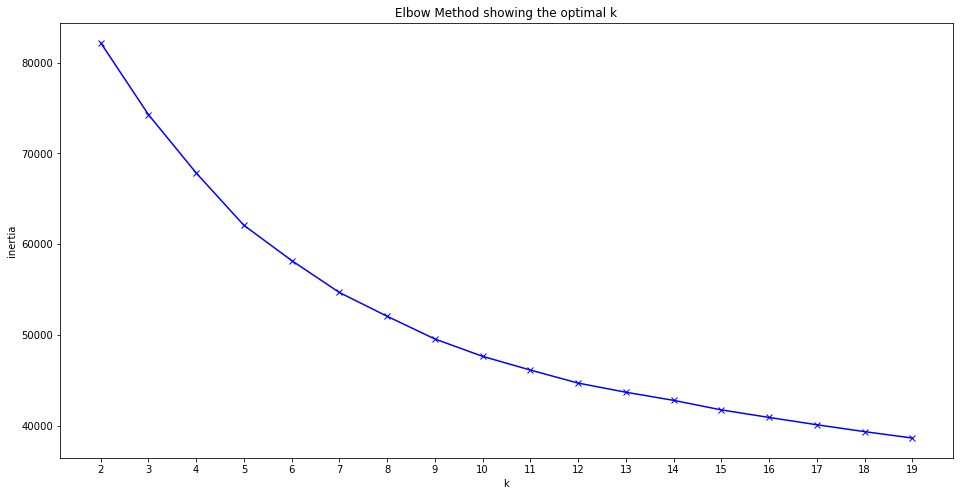

In [29]:
K = range(2, 20)

inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                   random_state=42)
    kmeans.fit(playlist_scaled)
    inertia.append(kmeans.inertia_)

print(inertia)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the results
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

plt.show()

The plot is quite smooth.Hence, we'll use another another metric that will help us decide.

## Silhoutte Score

In [18]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(playlist_scaled)
    silhouette.append(silhouette_score(X=playlist_scaled, labels=kmeans.predict(playlist_scaled)))


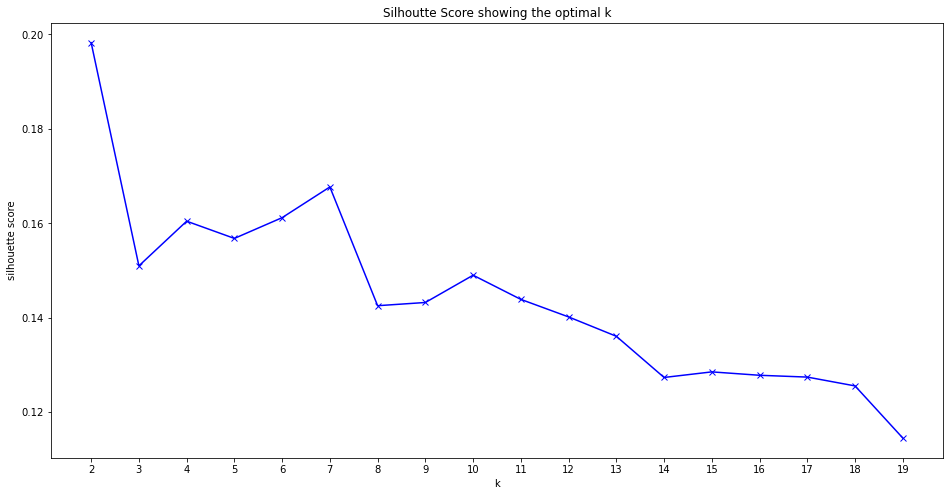

In [19]:
# Plot the results
plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhoutte Score showing the optimal k')

plt.show()

The greater the Silouhette, the greater the separation between the clusters, In other words, the clusters will be more defined.

Looking into the results, the Elbow Method doesn't show us a clear winner for the n_clusters we should use. On the other hand, thanks to the Silhoutte Score we see that this score reach it's peak at 7. For that, we will redo the clustering with this new value in mind.


## Running the Final Model

In [20]:
# intilize the model
kmeans = KMeans(n_clusters=7, random_state=42)

# fit the model
kmeans.fit(playlist_scaled)

# Predicting clusters
clusters = kmeans.predict(playlist_scaled)

In [21]:
pd.Series(clusters).value_counts()

2    3132
4    2312
0    2110
3     901
1     690
6     645
5     157
dtype: int64

## Adding Clusters to the Original File
After identifying each song on the correct cluster, we need to add this column to the original CSV file for running the final model on the next Jupyter Notebook.

In [22]:
spotify_playlist["cluster"] = clusters

In [25]:
spotify_playlist

,song,artist,duration,danceability,energy,acousticness,instrumentalness,liveness,loudness,speechiness,valence,tempo,cluster
0,Like a Rolling Stone,Bob Dylan,369600,0.482,0.721,0.731000,0.000000,0.1890,-6.839,0.0321,0.557,95.263,4
1,Smells Like Teen Spirit,Nirvana,301240,0.485,0.863,0.000012,0.016200,0.1380,-9.027,0.0495,0.767,116.835,4
2,A Day In The Life - Remastered,The Beatles,337413,0.364,0.457,0.290000,0.000106,0.9220,-14.162,0.0675,0.175,163.219,1
3,Good Vibrations (Mono),The Beach Boys,219146,0.398,0.413,0.082200,0.000025,0.0891,-10.934,0.0388,0.331,133.574,4
4,Johnny B Goode,Chuck Berry,160892,0.518,0.756,0.735000,0.000062,0.3170,-10.851,0.0915,0.968,166.429,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9942,Into The Valley,Skids,199466,0.332,0.707,0.000012,0.006120,0.1100,-12.698,0.0361,0.652,144.815,4
9943,Tonight's Da Night,Redman,201800,0.464,0.749,0.224000,0.000046,0.3510,-8.564,0.4800,0.879,181.121,6
9944,Figure 8,FKA twigs,183040,0.694,0.710,0.527000,0.001350,0.0697,-9.793,0.3400,0.415,119.964,6
9945,Like An Angel,The Mighty Lemon Drops,222160,0.332,0.800,0.000368,0.001600,0.0850,-9.746,0.0326,0.832,149.240,4


In [24]:
# Storing it as a CSV
spotify_playlist.to_csv("../playlist_with_clusters.csv", index=False)